## 가설들

1. 문제 푼 시간

    1. 지나치게 빨리 푼 문제들은 찍은 문제들 일 수도 있지 않을까?\
        : 쉬운 문제면 실제로 빨리 풀 수도 있지 않을까?

    2. 너무 오래걸린 문제들은 어려워서 못 푼거일 수도 있을텐데\
        : 푼 시간의 상승 추세 꺾이는 지점을 찾아봐야겠다

    3. 한 시험지 내에서 푼 시간의 순서, 기간\
        : 문항번호 추정
        : 피로도 고려

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train = pd.read_csv('../data/train_data.csv')
test = pd.read_csv('../data/test_data.csv')

In [7]:
print(train.shape)
train.sample(10)

(2266586, 6)


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
1411289,2333,A030024002,A030000024,1,2020-03-17 11:05:36,334
1536151,2628,A030052003,A030000052,1,2020-06-25 08:17:23,409
382146,523,A070042006,A070000042,0,2020-06-11 01:57:24,1257
279566,380,A060083004,A060000083,1,2020-02-24 10:20:13,10606
611110,869,A020021003,A020000021,1,2020-03-28 11:14:58,7693
35051,48,A080024003,A080000024,0,2020-05-25 22:27:21,4682
1242877,1967,A080011002,A080000011,0,2020-03-20 17:51:42,4658
1281512,2058,A010071002,A010000071,0,2020-06-01 11:31:23,6455
2234182,6365,A080138005,A080000138,0,2020-11-19 06:21:04,8432
1351078,2204,A040034002,A040000034,1,2020-07-30 05:00:07,2065


In [8]:
print(test.shape)
test.sample(10)

(260114, 6)


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
85174,1071,A020040005,A020000040,1,2020-07-17 09:19:36,7925
205325,3241,A060046001,A060000046,1,2020-02-07 09:52:26,599
62893,772,A020057003,A020000057,1,2020-07-21 12:15:50,7926
62194,767,A030091002,A030000091,0,2020-06-17 07:35:57,452
53538,645,A060174004,A060000174,0,2020-08-14 03:01:52,10450
204431,3155,A010071003,A010000071,1,2020-06-18 05:11:07,6455
190440,2757,A050179001,A050000179,1,2020-09-01 02:29:14,10396
160059,2169,A080053002,A080000053,0,2020-05-22 06:16:12,4962
117121,1571,A020155006,A020000155,0,2020-10-19 03:52:36,8126
197185,2973,A010169001,A010000169,1,2020-09-08 02:46:17,7809


## 결측치

- 단 한 개도 없음
- 이상한 값 있는 지도 찾아볼게요

In [12]:
train.isna().sum()

userID              0
assessmentItemID    0
testId              0
answerCode          0
Timestamp           0
KnowledgeTag        0
dtype: int64

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260114 entries, 0 to 260113
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   userID            260114 non-null  int64 
 1   assessmentItemID  260114 non-null  object
 2   testId            260114 non-null  object
 3   answerCode        260114 non-null  int64 
 4   Timestamp         260114 non-null  object
 5   KnowledgeTag      260114 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 11.9+ MB


In [14]:
train.describe()

,userID,answerCode,KnowledgeTag
count,2.266586e+06,2.266586e+06,2.266586e+06
mean,2.087687e+03,6.543784e-01,4.909007e+03
std,1.589365e+03,4.755706e-01,3.302214e+03
min,0.000000e+00,0.000000e+00,2.300000e+01
25%,8.000000e+02,0.000000e+00,1.931000e+03
50%,1.748000e+03,1.000000e+00,5.258000e+03
75%,3.046000e+03,1.000000e+00,7.913000e+03
max,7.441000e+03,1.000000e+00,1.127100e+04


## 유저들 목록

유저들 아무도 안겹쳐!

user_ID 일치여부만 중요하고, 누가 누군지는 생각보다 안 중요할 수도?

그렇다면, 유저를 나타낼 수 있는건 뭐가 있을까?
userID, assessmentItemID, testId, answerCode, Timestamp, KnoledgeTag

근데, 이거 lstm 계열에서는 어떻게 처리했지?

In [24]:
train.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag'],
      dtype='object')

In [15]:
train.userID.nunique(), train.answerCode.nunique(), train.KnowledgeTag.nunique()

(6698, 2, 912)

In [16]:
test.userID.nunique(), test.answerCode.nunique(), test.KnowledgeTag.nunique()

(744, 3, 912)

In [18]:
users_test = list(test.userID.unique())
users_train = list(train.userID.unique())

count = 0

for user in users_train:
    if user in users_test:
        count += 1

print(count / len(users_train))

0.0


In [7]:
train.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag'],
      dtype='object')

In [24]:
a = train.groupby('userID').apply(lambda r: (r['testId'].values, r['assessmentItemID'].values)).values

a.shape, len(a[0][0])

# userID당 2개의 튜플로 이루어진 tuple (testID...., assesmenItemID.....)

((6698,), 745)

In [21]:
test.answerCode.value_counts()

answerCode
 1    170383
 0     88987
-1       744
Name: count, dtype: int64

In [29]:
test.groupby('userID')['answerCode'].agg({'count'}).sort_values(by='count')

,count
userID,
7417,15
7416,15
7404,15
7373,15
7033,15
...,...
203,1318
617,1333
260,1335


In [30]:
train['Timestamp'] = pd.to_datetime(train['Timestamp'])

train.groupby('userID')['Timestamp'].max()

userID
0      2020-12-23 03:40:19
1      2020-11-13 02:47:20
2      2020-10-20 11:32:26
5      2020-12-11 22:48:28
6      2020-10-26 09:52:14
               ...        
7436   2020-04-08 12:07:21
7437   2020-05-22 01:53:49
7438   2020-10-19 10:28:29
7440   2020-10-21 08:33:20
7441   2020-08-21 01:08:49
Name: Timestamp, Length: 6698, dtype: datetime64[ns]

In [32]:
from datetime import timedelta

train.groupby('userID')['Timestamp'].max() - timedelta(7)

userID
0      2020-12-16 03:40:19
1      2020-11-06 02:47:20
2      2020-10-13 11:32:26
5      2020-12-04 22:48:28
6      2020-10-19 09:52:14
               ...        
7436   2020-04-01 12:07:21
7437   2020-05-15 01:53:49
7438   2020-10-12 10:28:29
7440   2020-10-14 08:33:20
7441   2020-08-14 01:08:49
Name: Timestamp, Length: 6698, dtype: datetime64[ns]

In [33]:
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,hour
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0


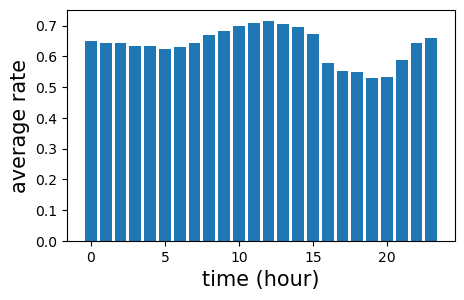

In [38]:
train['hour'] = train['Timestamp'].dt.hour

a = train.groupby('hour').answerCode.mean()

plt.figure(figsize=(5,3))
plt.bar(a.index, a.values)

plt.xlabel('time (hour)', fontsize=15)
plt.ylabel('average rate', fontsize=15)

plt.show()

ValueError: setting an array element with a sequence.

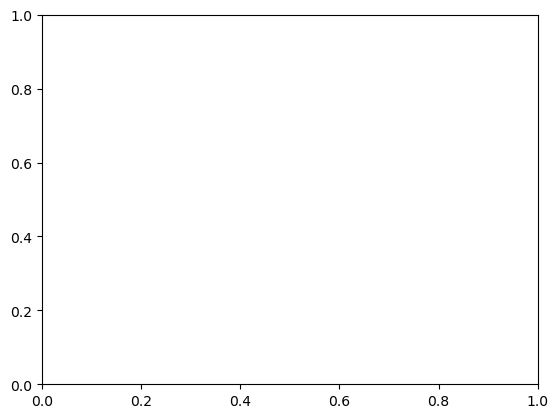

In [40]:
plt.plot(train.groupby('userID').answerCode.rolling(10).mean())
plt.show()

In [41]:
train.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'hour'],
      dtype='object')

In [44]:
testids_train = list(train.testId.unique())
testids_test = list(test.testId.unique())

count=0
for id in testids_test:
    if id in testids_train:
        count += 1

print(count)

1537


In [46]:
len(testids_test)

1537

In [50]:
train.userID.nunique(), train.testId.nunique(), test.testId.nunique(), train.assessmentItemID.nunique()

(6698, 1537, 1537, 9454)

In [54]:
train.groupby(['userID','testId']).assessmentItemID.nunique()

userID  testId    
0       A020000172    6
        A020000174    5
        A020000181    6
        A020000182    5
        A020000183    7
                     ..
7440    A030000136    5
        A030000197    5
        A050000096    5
7441    A030000071    5
        A040000165    4
Name: assessmentItemID, Length: 365164, dtype: int64

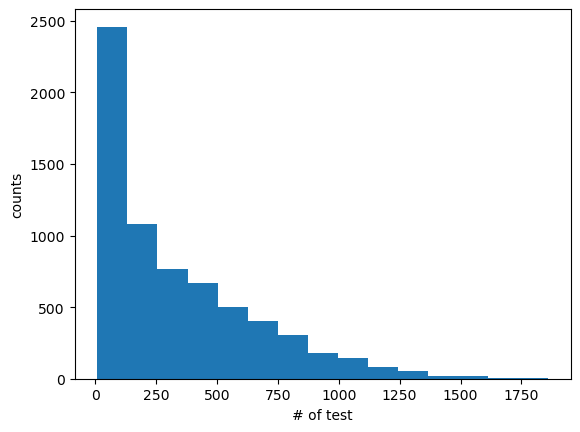

In [63]:
b = train.groupby('userID')['assessmentItemID'].count()

plt.hist(b, bins=15)

plt.xlabel('# of test')
plt.ylabel('counts')

plt.show()